In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from ast import literal_eval
import numpy as np

# Load the data
df = pd.read_csv("calculated_data2.csv", delim_whitespace=True)

# Print initial shape and column names
print("Initial shape:", df.shape)
print("Column names:", df.columns)

# Remove the drop statement for 'ID' if it's not present
# df = df.drop(columns=['ID'])  # Remove or comment this line if 'ID' is not a column

# Convert string lists to actual lists
def string_to_float_list(s):
    try:
        return literal_eval(s)
    except:
        return [float('nan')] * 10

df['NDVI'] = df['NDVI'].apply(string_to_float_list)
df['NBR'] = df['NBR'].apply(string_to_float_list)

# Expand these lists into separate columns
max_length = max(max(len(item) for item in df['NDVI']), max(len(item) for item in df['NBR']))
for i in range(max_length):
    df[f'NDVI_{i}'] = df['NDVI'].apply(lambda x: x[i] if i < len(x) else float('nan'))
    df[f'NBR_{i}'] = df['NBR'].apply(lambda x: x[i] if i < len(x) else float('nan'))

# Drop original columns
df.drop(['NDVI', 'NBR'], axis=1, inplace=True)

# Fill NaN values with a placeholder, like 0
df.fillna(0, inplace=True)

# Check the shape after handling NaNs
print("Shape after handling NaNs:", df.shape)

# Proceed if DataFrame is not empty
if df.shape[0] > 0:
    # Scaling the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df.drop('Label', axis=1))

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['Label'], test_size=0.20, random_state=42)

    # Train KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=12, metric='euclidean', weights='uniform')
    knn.fit(X_train, y_train)

    # Predictions and Evaluation
    pred = knn.predict(X_test)
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))



Initial shape: (919, 4)
Column names: Index(['ID', 'NDVI', 'NBR', 'Label'], dtype='object')
Shape after handling NaNs: (919, 22)
[[383  23   0   0]
 [129  17   0   0]
 [ 57   6   0   0]
 [ 27   2   0   0]]
              precision    recall  f1-score   support

         0.0       0.64      0.94      0.76       406
         1.0       0.35      0.12      0.18       146
         2.0       0.00      0.00      0.00        63
         3.0       0.00      0.00      0.00        29

    accuracy                           0.62       644
   macro avg       0.25      0.26      0.23       644
weighted avg       0.49      0.62      0.52       644



/Users/lilllmeng/Library/Caches/pypoetry/virtualenvs/mine-seg-sat-xju_6twP-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilllmeng/Library/Caches/pypoetry/virtualenvs/mine-seg-sat-xju_6twP-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lilllmeng/Library/Caches/pypoetry/virtualenvs/mine-seg-sat-xju_6twP-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in la

In [5]:
from sklearn.model_selection import GridSearchCV
# Fine-tuning the model using Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 12, 13, 14, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, wei

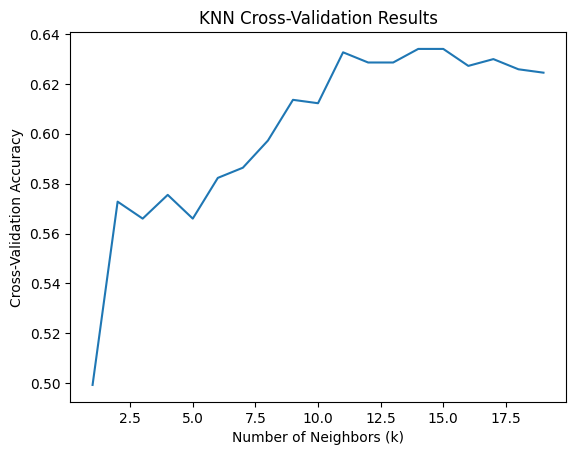

The optimal number of neighbors is 14


In [6]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Range of k values to test; ensuring k is less than the number of samples
k_values = range(1, min(20, len(X_train) - 1))

# List to store cross-validation scores
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=min(5, len(X_train)))
    cv_scores.append(scores.mean())

# Find the k value with the maximum score
optimal_k = k_values[cv_scores.index(max(cv_scores))]

# Plotting k values against cross-validation scores
plt.plot(k_values, cv_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Cross-Validation Results')
plt.show()

print(f"The optimal number of neighbors is {optimal_k}")


In [4]:
from sklearn.inspection import permutation_importance

# Assume knn is your trained KNN model and X_test, y_test are your test data
result = permutation_importance(knn, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Get importances and their standard deviations
importances = result.importances_mean
std = result.importances_std

# Displaying feature importances
for feature, importance, std in zip(['NDVI', 'NBR'], importances, std):
    print(f"Feature: {feature}, Importance: {importance} ± {std}")


Feature: NDVI, Importance: 0.023007246376811605 ± 0.01350944071558128
Feature: NBR, Importance: 0.0 ± 0.0
